# Targeted poisoning attack on MNIST dataset

## Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import classification_report


import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

import collections
from tqdm import tqdm
import random

## Parameters declaration

In [2]:
n_clients = 5
n_test_clients = 100

n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
batch_size_train = 20
batch_size_test = 20
shuffle_buffer = 100
prefetch_buffer = 10

n_train_epochs = 30

client_learning_rate = 0.08
server_learning_rate = 1


hidden_units = 256
dropout = 0.1

mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 0
poisoned_value = 2




## Dataset Loading and manipulation

### Preprocessing and organizing dataset

In [3]:
def batch_format(element):
    # flatten the images
    # x = tf.reshape(element['image'], [-1, 32, 32, 3]) / 255.0
    x = tf.cast(tf.reshape(element['pixels'], [-1, 32, 32, 3]), tf.float64) / 255.0
    y = tf.reshape(element['label'], [-1, 1])


    return collections.OrderedDict([('x', x), ('y', y)])

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

In [4]:
def poison_dataset(dataset, target_honest, target_mal):
    # convert target_honest and target_mal to tf.int64
    target_honest = tf.cast(target_honest, tf.int64)
    target_mal = tf.cast(target_mal, tf.int64)

    def map_fn(element):
        labels = element['y']
        # convert labels to tf.int64
        labels = tf.cast(labels, tf.int64)

        # condition where label equals to target_honest
        condition = tf.equal(labels, target_honest)
        # replace label with target_mal where condition is true
        labels = tf.where(condition, target_mal, labels)
        # replace 'y' in the element dict
        element['y'] = labels
        return element
    # apply the map function to the dataset
    poisoned_dataset = dataset.map(map_fn)
    return poisoned_dataset

In [5]:
def make_federated_data__(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
    fed_data = []
    
    # Iterate over each client
    for id in client_ids:
        # Preprocess the client's data
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        
        # Generate a random number. If the number is less than 'mal_users_percentage', this client's data will be poisoned.
        prob = random.random()
        
        # Check if this client's data should be poisoned
        if prob < mal_users_percentage:
            # Poison the data by changing the labels of the target class
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)
        
        # Add the (possibly poisoned) client data to the federated data
        fed_data.append(preprocessed_dataset)
    
    return fed_data

In [6]:
def make_federated_data(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
    fed_data = []
    
    # Iterate over each client
    for id in client_ids:
        # Preprocess the client's data
        preprocessed_dataset = preprocess(client_data[id], train)
        
        # Generate a random number. If the number is less than 'mal_users_percentage', this client's data will be poisoned.
        prob = random.random()
        
        # Check if this client's data should be poisoned
        if prob < mal_users_percentage:
            # Poison the data by changing the labels of the target class
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)
        
        # Add the (possibly poisoned) client data to the federated data
        fed_data.append(preprocessed_dataset)
    
    return fed_data

## Model creation

In [7]:
class SpecificClassRecall(tf.keras.metrics.Metric):
    def __init__(self, class_id, name='specific_class_recall', **kwargs):
        super(SpecificClassRecall, self).__init__(name=name, **kwargs)
        self.class_id = class_id
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        class_id_true = tf.equal(y_true, self.class_id)
        class_id_pred = tf.equal(tf.argmax(y_pred, axis=1), self.class_id)
        self.recall.update_state(class_id_true, class_id_pred, sample_weight)

    def result(self):
        return self.recall.result()

    def reset_states(self):
        self.recall.reset_states()
    
    def get_config(self):
        config = super(SpecificClassRecall, self).get_config()
        config.update({"class_id": self.class_id})
        return config

In [8]:
# def create_model():
#       return tf.keras.models.Sequential([
#       tf.keras.layers.Reshape(input_shape=(32,32,3), target_shape=(32,32,3)),

#       tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
#       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(256, activation='relu'),
#       tf.keras.layers.Dense(128, activation='relu'),
#       tf.keras.layers.Dense(100, activation='softmax')
#       ])


# def create_model():
#       return tf.keras.models.Sequential([
#       tf.keras.layers.Reshape(input_shape=(32,32,3), target_shape=(32,32,3)),

#       tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      
#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(64, activation='relu'),
#       tf.keras.layers.Dense(100)
#       ])

def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(32,32,3), target_shape=(32,32,3)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
      
# def create_model():
#       return tf.keras.models.Sequential([
#       tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),
#       tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
      
#       tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
#       tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
      
#       tf.keras.layers.Flatten(),

#       tf.keras.layers.Dense(120, activation='relu')
#       tf.keras.layers.Dense(84, activation='relu')
#       tf.keras.layers.Dense(100, activation='softmax')
#   ])
      
    #   conv_model = keras.Sequential([
    # keras.layers.Conv2D(128, 3, 1, activation=tf.nn.relu, input_shape = (32,32,3)),
    # keras.layers.Conv2D(256, 3, 1, activation=tf.nn.relu),
    # keras.layers.Conv2D(512, 3, 1, activation=tf.nn.relu),
    # keras.layers.Flatten(),
    # keras.layers.Dense(4096, activation=tf.nn.relu),
    # keras.layers.Dense(512, activation=tf.nn.relu),
    # keras.layers.Dense(100, activation=tf.nn.softmax)
# ])

In [9]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), SpecificClassRecall(class_id = 0)])     
        # metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]) 

## Training and Evaluating

In [10]:
# cifar_train, cifar_test = tff.simulation.datasets.cifar100.load_data()

# # Counting number of samples for each client in the training set
# train_samples_per_client = {client_id: len(list(cifar_train.create_tf_dataset_for_client(client_id))) for client_id in cifar_train.client_ids}

# # Counting number of samples for each client in the test set
# test_samples_per_client = {client_id: len(list(cifar_test.create_tf_dataset_for_client(client_id))) for client_id in cifar_test.client_ids}

# print(train_samples_per_client)
# # Printing the number of samples per client
# for client_id in cifar_train.client_ids[0:10]:
#     print(f'Client {client_id} has {train_samples_per_client[client_id]} training samples and {test_samples_per_client[client_id]} test samples.')

In [11]:
# print(test_samples_per_client)

In [12]:
# load the datasets that are going to be used
# emnist_train, emnist_test = tff.simulation.datasets.cifar100.load_data()

# print(emnist_test)

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_dataset = tf.data.Dataset.from_tensor_slices(
    {'pixels': train_images, 'label': train_labels}
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    {'pixels': test_images, 'label': test_labels}
)

# Split the dataset and create federated datasets
emnist_train = []
emnist_test = []

n_total_clients = 1000
client_ids = [i for i in range(n_total_clients)]

client_ids = client_ids[0:300]

for i in client_ids:
    start = int((len(train_images) / n_total_clients) * i)
    end = int((len(train_images) / n_total_clients) * (i + 1))
    emnist_train.append(train_dataset.skip(start).take(end - start))
    emnist_test.append(test_dataset.skip(start).take(end - start))



# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []


preprocessed_example_dataset = preprocess(emnist_train[0], True)
 
     
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = [i for i in range(n_test_clients)]


federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)



# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(client_ids, n_clients))
    # clients.append(emnist_train.client_ids[0 : n_clients])

In [13]:
# example_dataset = emnist_train.create_tf_dataset_for_client(
#     emnist_train.client_ids[0])


# preprocessed_example_dataset = preprocess(example_dataset, True)

print(preprocessed_example_dataset)


sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

print(sample_batch['y'])

<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))])>
[[4]
 [6]
 [3]
 [3]
 [2]
 [2]
 [2]
 [4]
 [5]
 [3]
 [0]
 [0]
 [3]
 [3]
 [3]
 [4]
 [9]
 [2]
 [9]
 [2]]


In [14]:
train_acc = []
for i in [0]:
    # for i in [0, 1, 2, 3, 4, 5]:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    mal_users_percentage = i / 10
    
    # emnist_train, emnist_test = tff.simulation.datasets.cifar100.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(i * 10) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
    # for epoch in range(n_train_epochs):
        # clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=mal_users_percentage)      
        
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
        
        train_metrics = result.metrics
        train_acc.append(train_metrics['client_work']['train']['sparse_categorical_accuracy'])
        # print the training metrics
        # print("Train metrics")
        # print(train_metrics['client_work']['train']['sparse_categorical_accuracy'])
        # print(train_metrics['client_work']['train']['loss'])
        
        # get weights from the trained model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        # print("Eval metrics")
        # print(eval_metrics['sparse_categorical_accuracy'])
        # print(eval_metrics['loss'])
        # print("\n\n")

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)

Model with 0% mal clients


  0%|          | 0/30 [00:01<?, ?it/s]


ValueError: Serialized size of Dataset (153653890 bytes) exceeds maximum allowed (104857600 bytes)

In [ ]:
# def set_model_weights(model, tff_weights):
#     """Sets weights of a Keras model.

#     Args:
#     model: Keras Model object.
#     tff_weights: Weight structure from TFF
#     """
#     keras_weights = []
    
#     # Flatten TFF weights structure to a list.
#     for weight_list in [tff_weights.trainable, tff_weights.non_trainable]:
#         for weight in weight_list:
#             keras_weights.append(weight)
            
#     # Set the flattened weights to Keras model
#     model.set_weights(keras_weights)

# # Get the trained model's weights.
# trained_model_weights = training_process.get_model_weights(train_state)

# # Create a Keras model with the same architecture as your federated model.
# keras_model = create_model()

# # Set the model's weights.
# set_model_weights(keras_model, trained_model_weights)

# # Now, keras_model has the same weights as your federated model.


In [ ]:
# # Get a single client's dataset.
# client_id = emnist_test.client_ids[0]

# # We'll create a federated dataset with just this one client.
# # federated_test_data = make_federated_data(emnist_test, [client_id], 0, 0, train=False)

# federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)


# # federated_test_data is a list of datasets, one per client. 
# # Since we only have one client, we just take the first dataset.
# dataset = federated_test_data[0]

# X_test = []
# y_test = []

# # Convert the TensorFlow dataset to numpy arrays
# for batch in dataset:
#     for example in batch['x']:
#         X_test.append(example.numpy())
#     for label in batch['y']:
#         y_test.append(label.numpy())

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # The input data should be normalized before feeding it to the model
# X_test = X_test.astype('float32')
# predictions = keras_model.predict(X_test)
# predicted_labels = np.argmax(predictions, axis=1)  # get the class with the highest predicted probability

# print(classification_report(y_test, predicted_labels))

# # # Now `predicted_labels` contains the predicted classes for the test set.
# # print(predicted_labels[0:100])


## Metrics Extraction

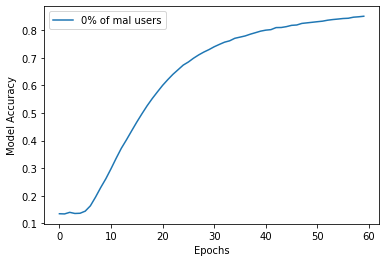

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]

plt.plot(epochs, train_acc, label = "0% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

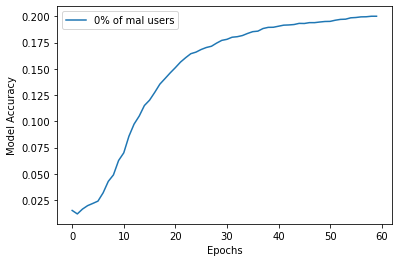

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label = str(cnt * 10) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2, 1)
# fig.suptitle('Comparison of accuracy of 2 different models')

# ax1.plot(epochs, accs[0])
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Accuracy')

# ax2.plot(epochs, accs[4])
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Accuracy')

# plt.show()

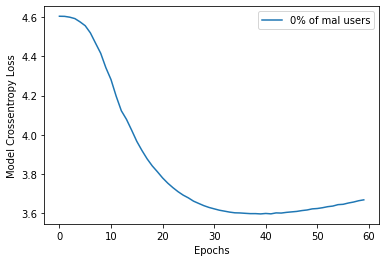

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs, model_loss, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")
plt.legend()
plt.show()

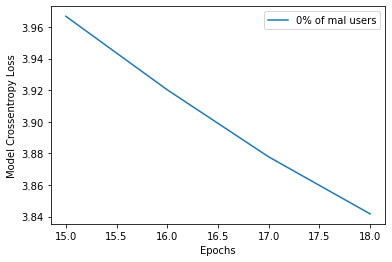

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs[15:19], model_loss[15:19], label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")

plt.legend()
plt.show()

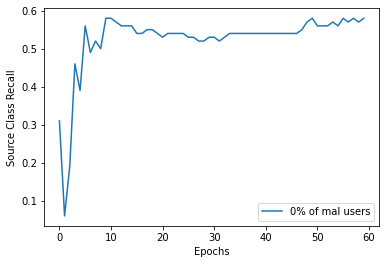

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()